                                        productTitle originalPrice    price  \
0  Dresser For Bedroom With 9 Fabric Drawers Ward...           NaN   $46.79   
1  Outdoor Conversation Set 4 Pieces Patio Furnit...           NaN  $169.72   
2  Desser For Bedroom With 7 Fabric Drawers Organ...         $78.4   $39.46   
3  Modern Accent Boucle Chair,Upholstered Tufted ...           NaN  $111.99   
4  Small Unit Simple Computer Desk Household Wood...        $48.82   $21.37   

   sold        tagText  
0   600  Free shipping  
1     0  Free shipping  
2     7  Free shipping  
3     0  Free shipping  
4     1  Free shipping  
productTitle        0
originalPrice    1513
price               0
sold                0
tagText             3
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 487 entries, 2 to 1983
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   productTitle   487 non-null    object
 1   originalPrice  487

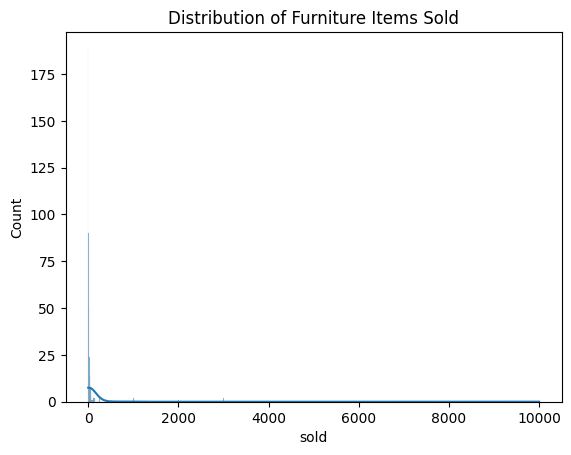

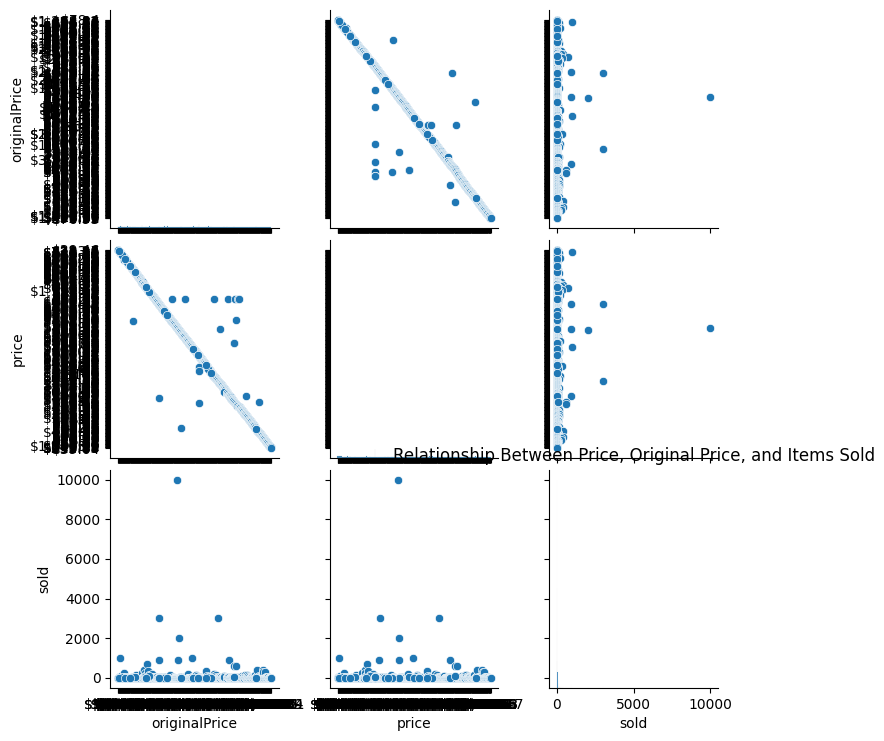

Linear Regression MSE: 79047.24855205599, R2: 0.005461651691664349
Random Forest MSE: 97346.90311510347, R2: -0.22477670014370732


In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('/content/ecommerce_furniture_dataset_2024.csv')

# View the first few rows of the dataset
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Dropping any rows with missing values
df = df.dropna()

# Convert tagText into a categorical feature
df['tagText'] = df['tagText'].astype('category').cat.codes

# Check data types
print(df.info())

# Distribution of 'sold' values
sns.histplot(df['sold'], kde=True)
plt.title('Distribution of Furniture Items Sold')
plt.show()

# Plot the relationship between originalPrice, price, and sold
sns.pairplot(df, vars=['originalPrice', 'price', 'sold'], kind='scatter')
plt.title('Relationship Between Price, Original Price, and Items Sold')
plt.show()

# Create a new feature: percentage discount
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['originalPrice'] = df['originalPrice'].replace('[\$,]', '', regex=True).astype(float)
df['discount'] = ((1 - df['price'] / df['originalPrice'])) * 100

# Convert productTitle into a numeric feature using TF-IDFVectorizer
tfidf = TfidfVectorizer(max_features=100)
productTitle_tfidf = tfidf.fit_transform(df['productTitle'])
productTitle_tfidf_df = pd.DataFrame(productTitle_tfidf.toarray(), columns=tfidf.get_feature_names_out())
df = pd.concat([df, productTitle_tfidf_df], axis=1)
df = df.drop('productTitle', axis=1)

# Split the dataset into features (X) and target (y)
X = df.drop('sold', axis=1)
y = df['sold']
y = y.fillna(y.mean())
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fill missing values in X_train and X_test
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

# Check for non-numeric columns and encode them
non_numeric_columns = X_train.select_dtypes(include=['object']).columns
if len(non_numeric_columns) > 0:
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)
    # Align columns of X_test with X_train
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Train models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predict with Linear Regression
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Predict with Random Forest
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print model evaluation results
print(f'Linear Regression MSE: {mse_lr}, R2: {r2_lr}')
print(f'Random Forest MSE: {mse_rf}, R2: {r2_rf}')